# Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression,LogisticRegression 
from sklearn.svm import SVR
from sklearn import metrics
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from scipy.stats import uniform, randint as sp_randint
#from matplotlib import style

# Read Data

In [2]:
total_case_df = pd.read_excel("Case_Data.xlsx","Total Cases")
air_df = pd.read_csv("AQI_Data_31Jan2021.csv")
air_df.Date = pd.to_datetime(air_df.Date,dayfirst=True)

# Data Mining

In [3]:
air_df_copy=air_df.copy(deep=True)
#air_df=air_df_copy.copy(deep=True)
air_df.Date=air_df.Date+pd.to_timedelta(5,unit="d")

In [4]:
air_df.sort_values(by="Date",inplace=True)

In [5]:
air_df["City"].value_counts()

Delhi         6992
Mumbai        3864
Chennai       1472
Kolkata       1288
Pune          1288
Hyderabad     1104
Lucknow        736
Chandigarh     184
Ahmedabad      184
Name: City, dtype: int64

In [6]:
def data_mining (cases_city,aqi_city):
    case_df = total_case_df[total_case_df['District']==cases_city].transpose()
    case_df.drop(index=['State','District'],inplace=True)
    if len(case_df.columns)==1:
        case_df.columns=["Total Cases"]
    elif len(case_df.columns)==2:
        case_df.columns=["Total Cases","1"]
        case_df.drop(columns="1",inplace=True)
    case_df['Date'] = case_df.index
    first_index_value=case_df.first_valid_index()
    if case_df.loc[first_index_value,"Total Cases"]==np.nan:
        prev_value=0
    else:
        prev_value=case_df.loc[first_index_value,"Total Cases"]
        prev_date=case_df.loc[first_index_value,"Date"]
        daily_cases=0
    for i,row in case_df.iterrows():
        if(str(row["Total Cases"])!="nan"):
            if prev_date!=row["Date"]:
                daily_cases=row["Total Cases"]-prev_value
                case_df.at[i,"Total_Day_Cases"]=daily_cases
                prev_value=row["Total Cases"]
                prev_date=row["Date"]
            else:
                case_df.at[i,"Total_Day_Cases"]=daily_cases
    case_df.reset_index(drop=True, inplace=True)
    case_df = (air_df[air_df.City == aqi_city]).join(case_df.set_index('Date'),on='Date')
    return(case_df)

In [7]:
li=[]
aqi_city=['Delhi','Mumbai','Chennai','Kolkata','Hyderabad']
for i,city in enumerate(['Delhi','Mumbai City','Chennai','Kolkata','Hyderabad']):
    city_df=data_mining(city,aqi_city[i])
    li.append(city_df)
major_cities_df=pd.concat(li,ignore_index=False,axis=0)

In [8]:
major_cities_df["Total_Day_Cases"].sort_values()

5479    -819.0
7503    -819.0
15967   -819.0
13023   -819.0
11735   -819.0
         ...  
3864       NaN
184        NaN
9936       NaN
1288       NaN
14904      NaN
Name: Total_Day_Cases, Length: 14720, dtype: float64

In [9]:
major_cities_df.drop(columns = ['Unnamed: 0','State','Station_Name','NH3_average','NH3_minimum','NH3_maximum'],inplace=True)
pollutant_cols=list(major_cities_df.drop(columns=["City","Station_ID","Date","Total Cases","Total_Day_Cases"]).columns)
major_cities_df.dropna(subset=pollutant_cols,how="all",axis=0,inplace=True)
major_cities_df.dropna(subset=["Total Cases"],how="all",axis=0,inplace=True)
major_cities_df

,City,Station_ID,Date,PM2.5_average,PM2.5_minimum,PM2.5_maximum,PM10_average,PM10_minimum,PM10_maximum,NO2_average,...,SO2_minimum,SO2_maximum,CO_average,CO_minimum,CO_maximum,OZONE_average,OZONE_minimum,OZONE_maximum,Total Cases,Total_Day_Cases
17111,Delhi,site_106,2020-07-06,58.0,19.0,84.0,89.0,48.0,122.0,24.0,...,NaN,NaN,31.0,23.0,39.0,82.0,27.0,151.0,100823,1379.0
8463,Delhi,site_1435,2020-07-06,81.0,57.0,98.0,106.0,70.0,171.0,22.0,...,24.0,54.0,91.0,85.0,101.0,53.0,5.0,94.0,100823,1379.0
11959,Delhi,site_105,2020-07-06,70.0,44.0,93.0,86.0,48.0,120.0,11.0,...,NaN,NaN,33.0,30.0,35.0,55.0,32.0,68.0,100823,1379.0
7911,Delhi,site_124,2020-07-06,38.0,10.0,63.0,74.0,44.0,109.0,23.0,...,8.0,26.0,45.0,30.0,52.0,12.0,5.0,17.0,100823,1379.0
5151,Delhi,site_1427,2020-07-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,73.0,2.0,117.0,55.0,32.0,76.0,100823,1379.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10167,Hyderabad,site_262,2020-11-19,51.0,22.0,123.0,63.0,31.0,124.0,45.0,...,1.0,7.0,40.0,12.0,56.0,21.0,3.0,53.0,2683,0.0
1335,Hyderabad,site_294,2020-11-19,64.0,29.0,222.0,NaN,NaN,NaN,39.0,...,4.0,8.0,43.0,2.0,61.0,16.0,8.0,34.0,2683,0.0
9983,Hyderabad,site_298,2020-11-19,82.0,38.0,190.0,101.0,50.0,155.0,82.0,...,4.0,6.0,10.0,8.0,11.0,14.0,12.0,14.0,2683,0.0
14951,Hyderabad,site_275,2020-11-19,38.0,12.0,126.0,62.0,22.0,155.0,60.0,...,NaN,NaN,41.0,21.0,56.0,9.0,2.0,24.0,2683,0.0


In [10]:
final_df=major_cities_df.groupby(by=["City","Date"]).count().reset_index()[["City","Date"]]

In [11]:
final_df["Unique"]=final_df["City"]+"|"+final_df["Date"].astype('str')
major_cities_df["Unique"]=major_cities_df["City"]+"|"+major_cities_df["Date"].astype('str')

In [12]:
major_cities_df.columns

Index(['City', 'Station_ID', 'Date', 'PM2.5_average', 'PM2.5_minimum',
       'PM2.5_maximum', 'PM10_average', 'PM10_minimum', 'PM10_maximum',
       'NO2_average', 'NO2_minimum', 'NO2_maximum', 'SO2_average',
       'SO2_minimum', 'SO2_maximum', 'CO_average', 'CO_minimum', 'CO_maximum',
       'OZONE_average', 'OZONE_minimum', 'OZONE_maximum', 'Total Cases',
       'Total_Day_Cases', 'Unique'],
      dtype='object')

In [13]:
final_df

,City,Date,Unique
0,Chennai,2020-07-06,Chennai|2020-07-06
1,Chennai,2020-07-07,Chennai|2020-07-07
2,Chennai,2020-07-08,Chennai|2020-07-08
3,Chennai,2020-07-09,Chennai|2020-07-09
4,Chennai,2020-07-10,Chennai|2020-07-10
...,...,...,...
680,Mumbai,2020-11-15,Mumbai|2020-11-15
681,Mumbai,2020-11-16,Mumbai|2020-11-16
682,Mumbai,2020-11-17,Mumbai|2020-11-17
683,Mumbai,2020-11-18,Mumbai|2020-11-18


In [14]:
cols_with_na=major_cities_df.groupby(by=["Unique"]).max().columns[major_cities_df.groupby(by=["Unique"]).max().isna().any()]
cols_with_na

Index(['PM10_average', 'PM10_minimum', 'PM10_maximum'], dtype='object')

In [15]:
major_cities_df.drop(columns=cols_with_na,inplace=True)

In [16]:
for col in major_cities_df.select_dtypes(include=[np.number]).columns:
    groupby_citydate=major_cities_df.groupby(by=["Unique"])
    if(col.find('maximum')!=-1):
        group_df=pd.DataFrame(groupby_citydate.max()[col])
        final_df=final_df.join(group_df,on="Unique")
    elif(col.find('minimum')!=-1):
        group_df=pd.DataFrame(groupby_citydate.min()[col])
        final_df=final_df.join(group_df,on="Unique")
    else:
        group_df=pd.DataFrame(groupby_citydate.mean()[col])
        final_df=final_df.join(group_df,on="Unique")

In [17]:
final_df["Date"].sort_values()

0     2020-07-06
548   2020-07-06
137   2020-07-06
411   2020-07-06
274   2020-07-06
         ...    
410   2020-11-19
273   2020-11-19
136   2020-11-19
547   2020-11-19
684   2020-11-19
Name: Date, Length: 685, dtype: datetime64[ns]

In [18]:
final_df

,City,Date,Unique,PM2.5_average,PM2.5_minimum,PM2.5_maximum,NO2_average,NO2_minimum,NO2_maximum,SO2_average,SO2_minimum,SO2_maximum,CO_average,CO_minimum,CO_maximum,OZONE_average,OZONE_minimum,OZONE_maximum,Total_Day_Cases
0,Chennai,2020-07-06,Chennai|2020-07-06,24.000000,3.0,97.0,12.000000,1.0,101.0,10.333333,1.0,101.0,30.666667,5.0,58.0,52.666667,17.0,252.0,1763.0
1,Chennai,2020-07-07,Chennai|2020-07-07,25.500000,5.0,71.0,15.000000,2.0,55.0,13.000000,1.0,63.0,32.000000,6.0,61.0,44.500000,18.0,121.0,1213.0
2,Chennai,2020-07-08,Chennai|2020-07-08,30.000000,4.0,66.0,23.500000,8.0,65.0,7.500000,1.0,67.0,36.500000,2.0,62.0,62.000000,5.0,145.0,1270.0
3,Chennai,2020-07-09,Chennai|2020-07-09,22.000000,8.0,59.0,12.000000,8.0,15.0,25.000000,3.0,90.0,38.500000,28.0,101.0,36.500000,3.0,72.0,1228.0
4,Chennai,2020-07-10,Chennai|2020-07-10,16.666667,1.0,82.0,12.333333,1.0,53.0,7.333333,1.0,58.0,35.000000,10.0,58.0,65.000000,2.0,260.0,1241.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,Mumbai,2020-11-15,Mumbai|2020-11-15,130.750000,40.0,315.0,49.100000,1.0,173.0,15.444444,3.0,40.0,53.200000,16.0,118.0,20.000000,1.0,265.0,577.0
681,Mumbai,2020-11-16,Mumbai|2020-11-16,140.000000,50.0,310.0,54.111111,1.0,172.0,17.375000,4.0,56.0,42.909091,1.0,113.0,19.090909,1.0,240.0,409.0
682,Mumbai,2020-11-17,Mumbai|2020-11-17,167.900000,38.0,395.0,55.400000,1.0,189.0,14.800000,2.0,58.0,46.545455,1.0,98.0,24.333333,1.0,160.0,541.0
683,Mumbai,2020-11-18,Mumbai|2020-11-18,146.400000,35.0,390.0,55.600000,1.0,246.0,13.500000,1.0,69.0,56.083333,1.0,109.0,27.333333,1.0,275.0,871.0


In [19]:
#final_df['Date1'] = final_df.Date - pd.to_timedelta(2,unit="d")

In [20]:
final_df

,City,Date,Unique,PM2.5_average,PM2.5_minimum,PM2.5_maximum,NO2_average,NO2_minimum,NO2_maximum,SO2_average,SO2_minimum,SO2_maximum,CO_average,CO_minimum,CO_maximum,OZONE_average,OZONE_minimum,OZONE_maximum,Total_Day_Cases
0,Chennai,2020-07-06,Chennai|2020-07-06,24.000000,3.0,97.0,12.000000,1.0,101.0,10.333333,1.0,101.0,30.666667,5.0,58.0,52.666667,17.0,252.0,1763.0
1,Chennai,2020-07-07,Chennai|2020-07-07,25.500000,5.0,71.0,15.000000,2.0,55.0,13.000000,1.0,63.0,32.000000,6.0,61.0,44.500000,18.0,121.0,1213.0
2,Chennai,2020-07-08,Chennai|2020-07-08,30.000000,4.0,66.0,23.500000,8.0,65.0,7.500000,1.0,67.0,36.500000,2.0,62.0,62.000000,5.0,145.0,1270.0
3,Chennai,2020-07-09,Chennai|2020-07-09,22.000000,8.0,59.0,12.000000,8.0,15.0,25.000000,3.0,90.0,38.500000,28.0,101.0,36.500000,3.0,72.0,1228.0
4,Chennai,2020-07-10,Chennai|2020-07-10,16.666667,1.0,82.0,12.333333,1.0,53.0,7.333333,1.0,58.0,35.000000,10.0,58.0,65.000000,2.0,260.0,1241.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,Mumbai,2020-11-15,Mumbai|2020-11-15,130.750000,40.0,315.0,49.100000,1.0,173.0,15.444444,3.0,40.0,53.200000,16.0,118.0,20.000000,1.0,265.0,577.0
681,Mumbai,2020-11-16,Mumbai|2020-11-16,140.000000,50.0,310.0,54.111111,1.0,172.0,17.375000,4.0,56.0,42.909091,1.0,113.0,19.090909,1.0,240.0,409.0
682,Mumbai,2020-11-17,Mumbai|2020-11-17,167.900000,38.0,395.0,55.400000,1.0,189.0,14.800000,2.0,58.0,46.545455,1.0,98.0,24.333333,1.0,160.0,541.0
683,Mumbai,2020-11-18,Mumbai|2020-11-18,146.400000,35.0,390.0,55.600000,1.0,246.0,13.500000,1.0,69.0,56.083333,1.0,109.0,27.333333,1.0,275.0,871.0


Threshold of daily cases

In [21]:
#final_df_copy=final_df.copy(deep=True)
#final_df=final_df_copy.copy(deep=True)

In [22]:
#final_df.drop(final_df[final_df['Total_Day_Cases'] > 1500].index, inplace = True) 
#final_df.drop(final_df[final_df['Total_Day_Cases'] == 0].index, inplace = True) 

In [23]:
cols_with_na=final_df.groupby(by=["Unique"]).max().columns[final_df.groupby(by=["Unique"]).max().isna().any()]
cols_with_na

Index([], dtype='object')

In [24]:
corr_df=pd.DataFrame(final_df.corr())
corr_df

,PM2.5_average,PM2.5_minimum,PM2.5_maximum,NO2_average,NO2_minimum,NO2_maximum,SO2_average,SO2_minimum,SO2_maximum,CO_average,CO_minimum,CO_maximum,OZONE_average,OZONE_minimum,OZONE_maximum,Total_Day_Cases
PM2.5_average,1.000000,0.698462,0.750101,0.868159,0.378606,0.689647,0.453768,-0.058949,0.443605,0.801726,0.026752,0.630388,0.342736,-0.132058,0.649823,0.672047
PM2.5_minimum,0.698462,1.000000,0.410498,0.644630,0.427448,0.411853,0.305615,0.092907,0.253148,0.427350,0.167686,0.269882,0.263139,0.019215,0.329075,0.239122
PM2.5_maximum,0.750101,0.410498,1.000000,0.657819,0.180254,0.653177,0.302368,-0.176498,0.448768,0.751568,0.002022,0.690831,0.426133,-0.205167,0.714765,0.587876
NO2_average,0.868159,0.644630,0.657819,1.000000,0.432640,0.794492,0.363246,-0.071382,0.445365,0.683566,-0.017418,0.556661,0.248666,-0.160746,0.588123,0.497818
NO2_minimum,0.378606,0.427448,0.180254,0.432640,1.000000,0.194036,0.002898,0.155153,0.073345,0.259341,0.159789,0.118829,0.311516,0.151376,0.174170,0.073301
NO2_maximum,0.689647,0.411853,0.653177,0.794492,0.194036,1.000000,0.362067,-0.121575,0.471874,0.672592,-0.058482,0.616202,0.216058,-0.226948,0.648637,0.567829
SO2_average,0.453768,0.305615,0.302368,0.363246,0.002898,0.362067,1.000000,0.257077,0.637131,0.320468,-0.091430,0.282696,-0.109361,-0.213972,0.289046,0.481468
SO2_minimum,-0.058949,0.092907,-0.176498,-0.071382,0.155153,-0.121575,0.257077,1.000000,-0.055026,-0.125724,0.131515,-0.182627,-0.105249,0.110278,-0.159575,-0.152863
SO2_maximum,0.443605,0.253148,0.448768,0.445365,0.073345,0.471874,0.637131,-0.055026,1.000000,0.467764,-0.090383,0.459390,0.137918,-0.160390,0.456276,0.443305
CO_average,0.801726,0.427350,0.751568,0.683566,0.259341,0.672592,0.320468,-0.125724,0.467764,1.000000,0.104890,0.853749,0.391867,-0.143347,0.737088,0.702608


In [25]:
high_corr_cols=list(corr_df[(corr_df["Total_Day_Cases"]>0.2) | (corr_df["Total_Day_Cases"]<=-0.2)].index)
final_high_df=final_df[high_corr_cols]

In [26]:
high_corr_cols

['PM2.5_average',
 'PM2.5_minimum',
 'PM2.5_maximum',
 'NO2_average',
 'NO2_maximum',
 'SO2_average',
 'SO2_maximum',
 'CO_average',
 'CO_maximum',
 'OZONE_maximum',
 'Total_Day_Cases']

In [27]:
final_df.columns

Index(['City', 'Date', 'Unique', 'PM2.5_average', 'PM2.5_minimum',
       'PM2.5_maximum', 'NO2_average', 'NO2_minimum', 'NO2_maximum',
       'SO2_average', 'SO2_minimum', 'SO2_maximum', 'CO_average', 'CO_minimum',
       'CO_maximum', 'OZONE_average', 'OZONE_minimum', 'OZONE_maximum',
       'Total_Day_Cases'],
      dtype='object')

In [28]:
final_high_df=final_df[high_corr_cols]
high_corr_cols

['PM2.5_average',
 'PM2.5_minimum',
 'PM2.5_maximum',
 'NO2_average',
 'NO2_maximum',
 'SO2_average',
 'SO2_maximum',
 'CO_average',
 'CO_maximum',
 'OZONE_maximum',
 'Total_Day_Cases']

# Train Test Split

In [29]:
#final_high_df_1 = final_high_df.head(600)
#final_high_df_2 = final_high_df.tail(85)

In [33]:
x=final_high_df.drop(columns = ['Total_Day_Cases'])
y = final_high_df['Total_Day_Cases']

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)

In [35]:
x_train.shape

(479, 10)

# Linear Regression

In [36]:
model_lr = LinearRegression()
model_lr.fit(x_train,y_train)
y_pred = model_lr.predict(x_test)
result_lr = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
result_lr.head(5)

,Actual,Predicted
277,0.0,368.277179
264,7830.0,5844.616138
442,680.0,371.012179
444,684.0,664.960302
240,3259.0,3131.285185


Mean Absolute Error Test   : 505.34021583444286
Mean Absolute Error All    : 538.0606325162705


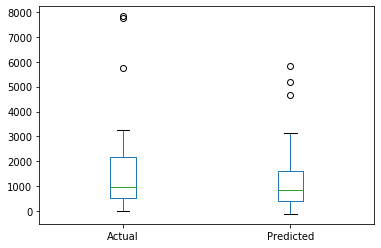

In [37]:
#print('Mean Absolute Error Train  :', metrics.mean_absolute_error(y_train, model_lr.predict(x_train)))
print('Mean Absolute Error Test   :', metrics.mean_absolute_error(y_test, model_lr.predict(x_test)))
print('Mean Absolute Error All    :', metrics.mean_absolute_error(y, model_lr.predict(x)))
#final_high_df[(final_high_df["Total_Day_Cases"]-final_high_df["Total_Cases_Predicted"])>500].shape
result_lr.head(20).plot(kind = 'box')

In [39]:
final_high_df["y_lr"]=model_lr.predict(x)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Logistic Regression

In [40]:
model_log = LogisticRegression()
model_log.fit(x_train,y_train)
y_pred = model_log.predict(x_test)
result_log = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
result_log.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


,Actual,Predicted
277,0.0,0.0
264,7830.0,7053.0
442,680.0,675.0
444,684.0,541.0
240,3259.0,3886.0


Mean Absolute Error Test   : 610.1359223300971
Mean Absolute Error All    : 237.71824817518248


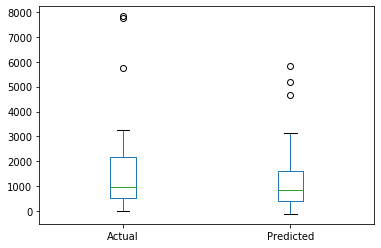

In [41]:
#print('Mean Absolute Error Train  :', metrics.mean_absolute_error(y_train, model_lr.predict(x_train)))
print('Mean Absolute Error Test   :', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Absolute Error All    :', metrics.mean_absolute_error(y, model_log.predict(x)))
#final_high_df[(final_high_df["Total_Day_Cases"]-final_high_df["Total_Cases_Predicted"])>500].shape
result_lr.head(20).plot(kind = 'box')

In [42]:
final_high_df["y_log"]=model_log.predict(x)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# SVR

In [43]:
model_svr = SVR(C=1.0, max_iter=200)
model_svr.fit(x_train, y_train)
y_pred = model_svr.predict(x_test)
result_svr = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
result_svr.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


,Actual,Predicted
277,0.0,899.5
264,7830.0,899.5
442,680.0,899.5
444,684.0,899.5
240,3259.0,899.5


Mean Absolute Error Test   : 875.9804914226761
Mean Absolute Error All    : 819.1349211012101


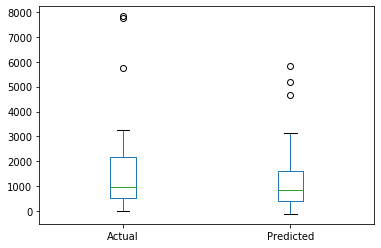

In [44]:
#print('Mean Absolute Error Train  :', metrics.mean_absolute_error(y_train, model_lr.predict(x_train)))
print('Mean Absolute Error Test   :', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Absolute Error All    :', metrics.mean_absolute_error(y, model_svr.predict(x)))
#final_high_df[(final_high_df["Total_Day_Cases"]-final_high_df["Total_Cases_Predicted"])>500].shape
result_lr.head(20).plot(kind = 'box')

In [45]:
final_high_df["y_svr"]=model_svr.predict(x)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


LGBM

In [46]:
lgb_model = LGBMRegressor(subsample=0.9)

params = {'learning_rate': uniform(0, 1),
          'n_estimators': sp_randint(200, 1500),
          'num_leaves': sp_randint(20, 200),
          'max_depth': sp_randint(2, 15),
          'min_child_weight': uniform(0, 2),
          'colsample_bytree': uniform(0, 1),
         }
lgb_random = RandomizedSearchCV(lgb_model, param_distributions=params, n_iter=10, cv=3, random_state=42, 
                                 verbose=10, return_train_score=True)
lgb_random = lgb_random.fit(x_train, y_train)
best_params = lgb_random.best_params_
model_lgbm = LGBMRegressor(**best_params, subsample=0.9, random_state=42, n_jobs=-1)
model_lgbm.fit(x_train, y_train)
y_pred = model_lgbm.predict(x_test)
result_lgbm = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
result_lgbm.head(5)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122, score=(train=0.991, test=0.286), total=   1.1s
[CV] colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122, score=(train=1.000, test=-0.055), total=   1.0s
[CV] colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV]  colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122, score=(train=1.000, test=0.448), total=   1.0s
[CV] colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=1323, num_leaves=123 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s


[CV]  colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=1323, num_leaves=123, score=(train=0.988, test=0.496), total=   1.2s
[CV] colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=1323, num_leaves=123 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.2s remaining:    0.0s


[CV]  colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=1323, num_leaves=123, score=(train=0.992, test=0.419), total=   1.0s
[CV] colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=1323, num_leaves=123 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.3s remaining:    0.0s


[CV]  colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=1323, num_leaves=123, score=(train=0.992, test=0.659), total=   1.4s
[CV] colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1005, num_leaves=149 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.8s remaining:    0.0s


[CV]  colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1005, num_leaves=149, score=(train=0.906, test=0.514), total=   0.4s
[CV] colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1005, num_leaves=149 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.2s remaining:    0.0s


[CV]  colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1005, num_leaves=149, score=(train=0.915, test=0.585), total=   0.4s
[CV] colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1005, num_leaves=149 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.6s remaining:    0.0s


[CV]  colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1005, num_leaves=149, score=(train=0.893, test=0.698), total=   0.4s
[CV] colsample_bytree=0.18182496720710062, learning_rate=0.18340450985343382, max_depth=13, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.1s remaining:    0.0s


[CV]  colsample_bytree=0.18182496720710062, learning_rate=0.18340450985343382, max_depth=13, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108, score=(train=0.977, test=0.458), total=   0.4s
[CV] colsample_bytree=0.18182496720710062, learning_rate=0.18340450985343382, max_depth=13, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108 
[CV]  colsample_bytree=0.18182496720710062, learning_rate=0.18340450985343382, max_depth=13, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108, score=(train=0.980, test=0.413), total=   0.4s
[CV] colsample_bytree=0.18182496720710062, learning_rate=0.18340450985343382, max_depth=13, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108 
[CV]  colsample_bytree=0.18182496720710062, learning_rate=0.18340450985343382, max_depth=13, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108, score=(train=0.978, test=0.617), total=   0.3s
[CV] colsample_bytree=0.2912291401980419,

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,Actual,Predicted
277,0.0,993.199394
264,7830.0,5615.415317
442,680.0,586.328998
444,684.0,1024.890247
240,3259.0,1092.249943


Mean Absolute Error Test   : 454.95059569154523
Mean Absolute Error All    : 325.3673029499095


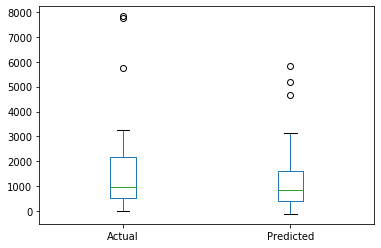

In [47]:
#print('Mean Absolute Error Train  :', metrics.mean_absolute_error(y_train, model_lr.predict(x_train)))
print('Mean Absolute Error Test   :', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Absolute Error All    :', metrics.mean_absolute_error(y, model_lgbm.predict(x)))
#final_high_df[(final_high_df["Total_Day_Cases"]-final_high_df["Total_Cases_Predicted"])>500].shape
result_lr.head(20).plot(kind = 'box')

In [48]:
final_high_df["y_lgbm"]=model_lgbm.predict(x)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Stacking

In [49]:
final_high_df.head(5)

,PM2.5_average,PM2.5_minimum,PM2.5_maximum,NO2_average,NO2_maximum,SO2_average,SO2_maximum,CO_average,CO_maximum,OZONE_maximum,Total_Day_Cases,y_lr,y_log,y_svr,y_lgbm
0,24.000000,3.0,97.0,12.000000,101.0,10.333333,101.0,30.666667,58.0,252.0,1763.0,1111.114879,1763.0,900.5,1562.632017
1,25.500000,5.0,71.0,15.000000,55.0,13.000000,63.0,32.000000,61.0,121.0,1213.0,885.037210,563.0,899.5,1000.091798
2,30.000000,4.0,66.0,23.500000,65.0,7.500000,67.0,36.500000,62.0,145.0,1270.0,513.133615,1270.0,900.5,631.443325
3,22.000000,8.0,59.0,12.000000,15.0,25.000000,90.0,38.500000,101.0,72.0,1228.0,1589.715701,1228.0,900.5,1233.521656
4,16.666667,1.0,82.0,12.333333,53.0,7.333333,58.0,35.000000,58.0,260.0,1241.0,798.607889,1241.0,900.5,1431.323113


Train Test split

In [50]:
X  = final_high_df.drop(columns = ['Total_Day_Cases'])
Y  = final_high_df['Total_Day_Cases']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

Linear Regression

Mean Absolute Error Test   : 526.1293860174361
Mean Absolute Error All    : 257.311380528056


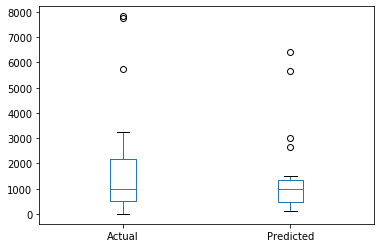

In [51]:
model_s_lr = LinearRegression()
model_s_lr.fit(X_train,Y_train)
Y_pred = model_s_lr.predict(X_test)
result_s_lr = pd.DataFrame({'Actual':Y_test,'Predicted':Y_pred})

#print('Mean Absolute Error Train  :', metrics.mean_absolute_error(y_train, model_lr.predict(x_train)))
print('Mean Absolute Error Test   :', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Absolute Error All    :', metrics.mean_absolute_error(Y, model_s_lr.predict(X)))
#final_high_df[(final_high_df["Total_Day_Cases"]-final_high_df["Total_Cases_Predicted"])>500].shape
result_s_lr.head(20).plot(kind = 'box')

Logistic Regression

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Mean Absolute Error Test   : 594.9902912621359
Mean Absolute Error All    : 186.8189781021898


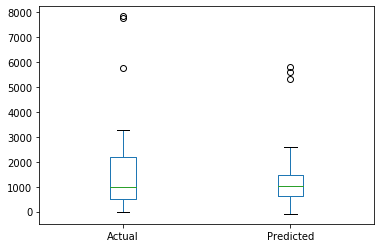

In [52]:
model_s_log = LogisticRegression()
model_s_log.fit(X_train,Y_train)
Y_pred = model_s_log.predict(X_test)
result_s_log = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})

#print('Mean Absolute Error Train  :', metrics.mean_absolute_error(y_train, model_lr.predict(x_train)))
print('Mean Absolute Error Test   :', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Absolute Error All    :', metrics.mean_absolute_error(Y, model_s_log.predict(X)))
#final_high_df[(final_high_df["Total_Day_Cases"]-final_high_df["Total_Cases_Predicted"])>500].shape
result_s_log.head(20).plot(kind = 'box')

In [54]:
X  = final_high_df.drop(columns = ['PM2.5_average','PM2.5_minimum','PM2.5_maximum','NO2_average','NO2_maximum','SO2_average',
                                  'SO2_maximum','CO_average','CO_maximum','OZONE_maximum','Total_Day_Cases'])
Y  = final_high_df['Total_Day_Cases']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

Mean Absolute Error Test   : 523.0865418854712
Mean Absolute Error All    : 257.8935470193574


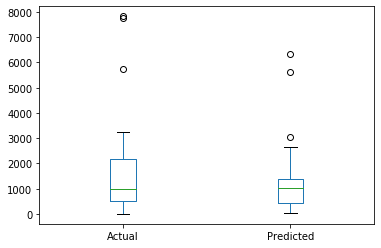

In [55]:
model_s_lr = LinearRegression()
model_s_lr.fit(X_train,Y_train)
Y_pred = model_s_lr.predict(X_test)
result_s_lr = pd.DataFrame({'Actual':Y_test,'Predicted':Y_pred})

#print('Mean Absolute Error Train  :', metrics.mean_absolute_error(y_train, model_lr.predict(x_train)))
print('Mean Absolute Error Test   :', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Absolute Error All    :', metrics.mean_absolute_error(Y, model_s_lr.predict(X)))
#final_high_df[(final_high_df["Total_Day_Cases"]-final_high_df["Total_Cases_Predicted"])>500].shape
result_s_lr.head(20).plot(kind = 'box')

In [58]:
final_high_df["Total_Cases_Predicted"]=model_s_lr.predict(X)
final_high_df[(final_high_df["Total_Day_Cases"]-final_high_df["Total_Cases_Predicted"])>500].shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(51, 16)

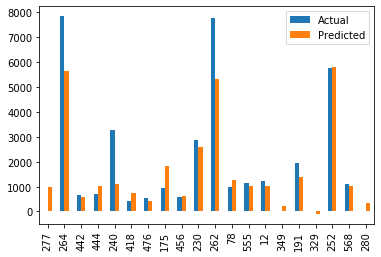

In [60]:
result_s_log.head(20).plot(kind = 'bar')